In [1]:
import random
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
import math
import scienceplots
import matplotlib as mpl
from tqdm import tqdm

In [24]:
#我们用y中加噪声进行贝叶斯优化optuna
import random
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import optuna
from tqdm import tqdm
device = torch.device('cpu')
# Set initial seed
SEED = 1234
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

# Define data
x = torch.unsqueeze(torch.linspace(-2, 10, 19), dim=1).to(device)
y=np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2 / 10) + 1 / (x**2 + 1) + 0.12 * torch.randn(x.size())

# Define network
class Net(torch.nn.Module):  # 定义网络
    def __init__(self, n_feature, n_hidden1, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # 全连接层
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # 输出层

    def forward(self, x):
        x = self.hidden1(x)
        x = torch.sigmoid(x)
        x = self.predict(x)  # 前向传播过程
        return x  

    def reset_parameters(self):
        # 重新初始化网络参数
        self.hidden1.reset_parameters()
        self.predict.reset_parameters()

# Optimization objective
def objective(trial):
    noise = trial.suggest_float('noise', 0, 0.2)
    net = Net(n_feature=1, n_hidden1=14, n_output=1).to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.99, 0.99))
    loss_func = nn.MSELoss().to(device)

    NJnum = 10
    epoch = 15000
    train_losses = []

    for num in range(NJnum):
        seed = random.sample(range(1, 1000), 1)[0]#选择一个随机种子
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        net.reset_parameters()#每次实验前重置网络参数
        # 在标签 y 中添加噪声
        ytrain =y+noise * torch.randn(x.size()).to(device)

        for _ in range(epoch):
            net.train()# 设定网络为训练模式
            prediction = net(x)
            loss = loss_func(prediction, ytrain)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_losses.append(loss.item()) # 记录本次训练的损失值

    train_loss = np.mean(train_losses) # 计算平均训练损失

    # Test phase
    seeds = random.sample(range(1, 1000), 10)
    test_losses = []

    for seed in seeds:
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        x_test = torch.unsqueeze(torch.linspace(-2, 10, 30), dim=1).to(device)
        y_test = np.exp(-(x_test - 2)**2) + np.exp(-(x_test - 6)**2 / 10) + 1 / (x_test**2 + 1) + 0.12 * torch.randn(x_test.size())+noise * torch.randn(x_test.size()).to(device)

        net.eval()# 设定网络为评估模式
        with torch.no_grad():
            prediction_test = net(x_test)
            test_loss = loss_func(prediction_test, y_test)
            test_losses.append(test_loss.item())

    mean_test_loss = np.mean(test_losses)

    return mean_test_loss

# Run optimization
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=SEED),  # Use TPE sampler with seed
    pruner=optuna.pruners.MedianPruner()  # Use median pruner for early stopping
)

study.optimize(objective, n_trials=20, show_progress_bar=True)

best_sigma = study.best_params["noise"]

[I 2024-07-06 23:38:02,145] A new study created in memory with name: no-name-69be5842-186a-495c-98ec-1293c95e8ee7


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-07-06 23:39:22,631] Trial 0 finished with value: 0.03672537710517645 and parameters: {'noise': 0.03830389007577846}. Best is trial 0 with value: 0.03672537710517645.
[I 2024-07-06 23:40:45,853] Trial 1 finished with value: 0.06939780190587044 and parameters: {'noise': 0.12442175420796638}. Best is trial 0 with value: 0.03672537710517645.
[I 2024-07-06 23:42:07,068] Trial 2 finished with value: 0.04996021427214146 and parameters: {'noise': 0.0875455478014229}. Best is trial 0 with value: 0.03672537710517645.
[I 2024-07-06 23:43:27,125] Trial 3 finished with value: 0.1370197430253029 and parameters: {'noise': 0.15707171674275386}. Best is trial 0 with value: 0.03672537710517645.
[I 2024-07-06 23:44:48,269] Trial 4 finished with value: 0.14775943160057067 and parameters: {'noise': 0.1559951616237607}. Best is trial 0 with value: 0.03672537710517645.
[I 2024-07-06 23:46:10,044] Trial 5 finished with value: 0.03688162229955196 and parameters: {'noise': 0.054518521056528324}. Best is

In [25]:
best_noise = study.best_params["noise"]
print(best_noise)

0.022996217420631376


Best hyperparameter (sigma): 0.022996217420631376
Mean Test Loss: 0.02674044407904148
Mean Train Loss: 0.0030092102475464343


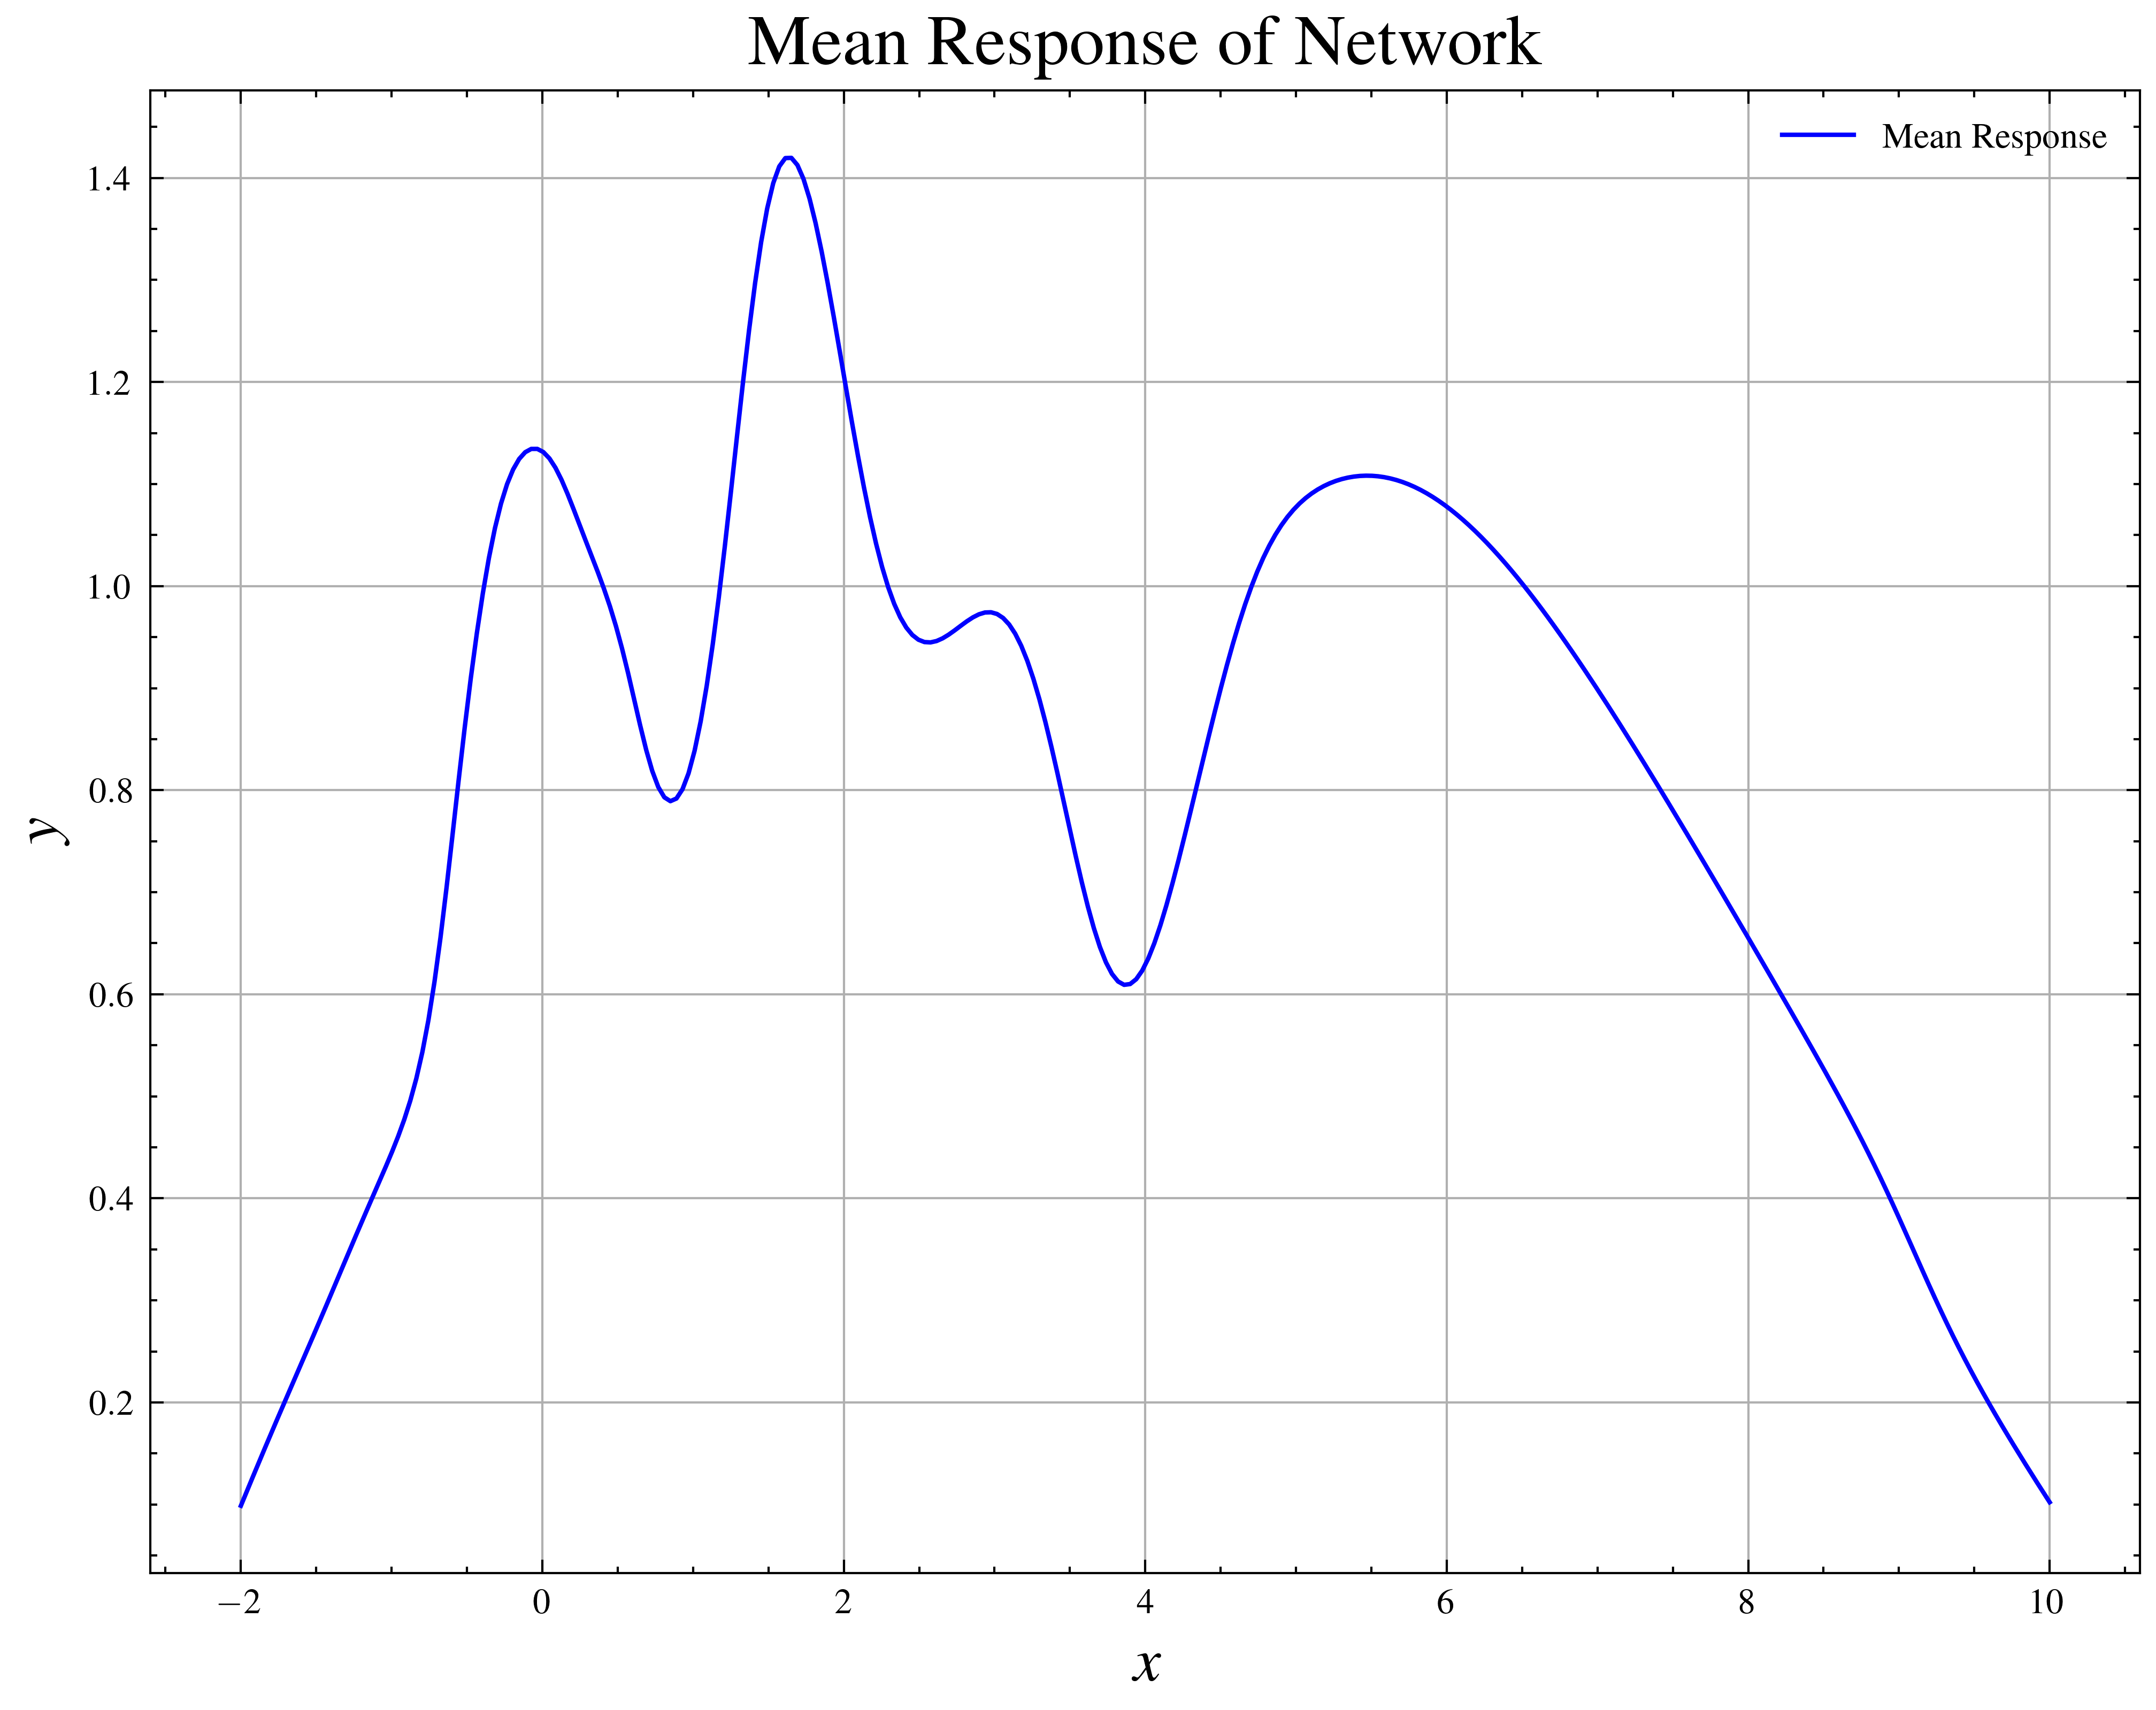

In [26]:
# Initialize hyperparameters and network
net = Net(n_feature=1, n_hidden1=14, n_output=1).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.99, 0.99))
loss_func = nn.MSELoss().to(device)

# Define training settings
NJnum = 10
epoch = 15000

x = torch.unsqueeze(torch.linspace(-2, 10, 19), dim=1).to(device)
y = np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2 / 10) + 1 / (x**2 + 1) + 0.12 * torch.randn(x.size())
# Define x_respond for response plotting
x_respond = torch.unsqueeze(torch.linspace(-2, 10, 300), dim=1)

# Initialize lists to store losses and responses
train_losses = []
responses = []

# Training loop with noisy data
for num in range(NJnum):
    seed = random.sample(range(1, 10000), 1)[0]
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    net.reset_parameters()
    # 在标签 y 中添加噪声
    ytrain = y + best_noise * torch.randn(x.size()).to(device)

    # Training loop
    for _ in range(epoch):
        net.train()
        prediction = net(x)
        loss = loss_func(prediction, ytrain)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Append the train loss
    train_losses.append(loss.item())

    # Calculate mean response for x_respond after training
    net.eval()
    with torch.no_grad():
        response = net(x_respond)
        responses.append(response.numpy())

# Calculate mean train loss
mean_train_loss = np.mean(train_losses)
# Calculate mean response across NJnum runs
mean_response = np.mean(responses, axis=0)

# Test phase
seeds = random.sample(range(1, 10000), 10)
test_losses = []

for seed in seeds:
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    x_test = torch.unsqueeze(torch.linspace(-2, 10, 30), dim=1).to(device)
    y_test = np.exp(-(x_test - 2)**2) + np.exp(-(x_test - 6)**2 / 10) + 1 / (x_test**2 + 1) + 0.12 * torch.randn(x_test.size()).to(device) + best_noise * torch.randn(x_test.size()).to(device)


    net.eval()
    with torch.no_grad():
        prediction_test = net(x_test)
        test_loss = loss_func(prediction_test, y_test)
        test_losses.append(test_loss.item())

mean_test_loss = np.mean(test_losses)

print("Best hyperparameter (sigma):", best_noise)
print("Mean Test Loss:", mean_test_loss)
print("Mean Train Loss:", mean_train_loss)

# Plotting responses
plt.figure(figsize=(8, 6))
plt.plot(x_respond.numpy(), mean_response, label='Mean Response', color='blue')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.title('Mean Response of Network', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()

In [27]:
# 将 x_respond 和 mean_response 保存到 CSV 文件
x_respond_np = x_respond.numpy()
output_data = np.hstack((x_respond_np, mean_response))
np.savetxt('D:/PycharmProjects/保存的参数/FOrestes（2）mean_response.csv', output_data, delimiter=',', header='x,mean_response', comments='')


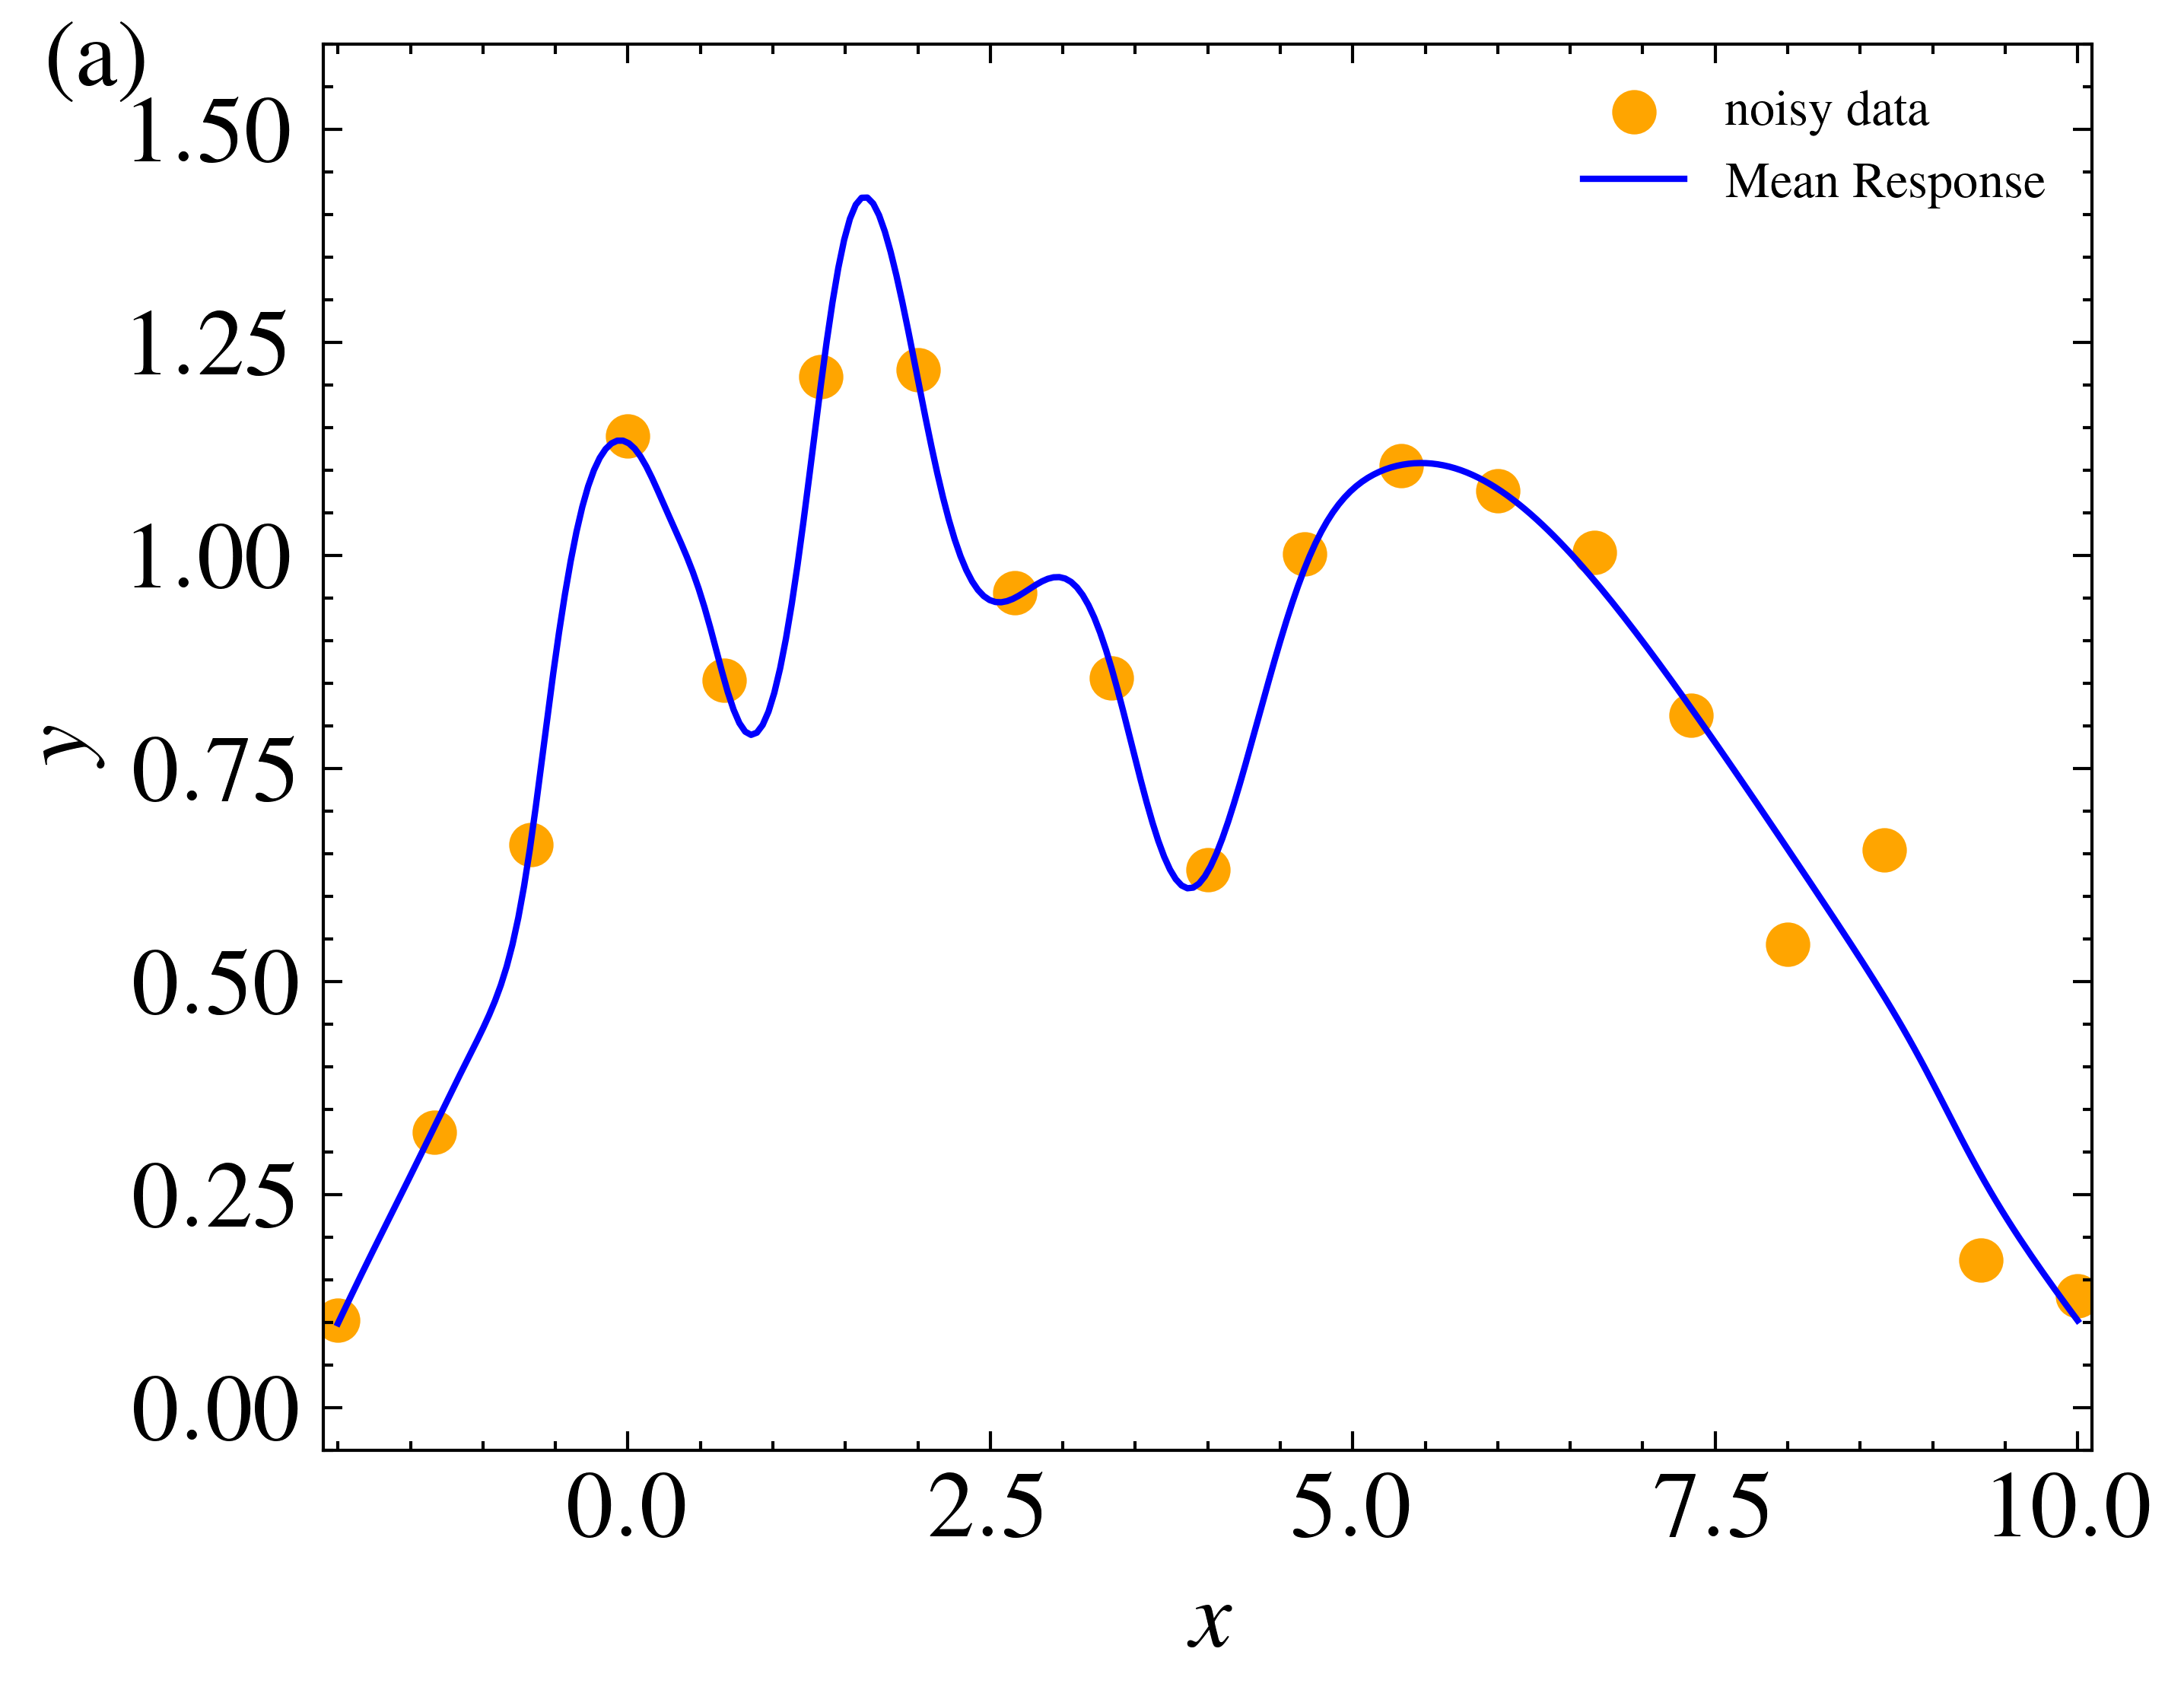

In [28]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# Configure plot settings
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = True
plt.style.use(['science', 'ieee'])
plt.rcParams['text.usetex'] = True
# Generate figure and axis
fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_xlim(-2.1, 10.1)
ax.set_ylim(-0.05, 1.6)

# Scatter plot for training set
ax.scatter(x.data.numpy(), y.data.numpy(), color="orange", label='noisy data')

plt.plot(x_respond.numpy(), mean_response, label='Mean Response', color='blue')


# Save output to CSV file
#output_data = np.hstack((inputx.data.numpy(), output.data.numpy()))
#np.savetxt('D:/PLA2024/outputsigmoidxnoise.csv', output_data, delimiter=',', header='x,output', comments='')
ax.text(-4, 1.55, '(a)',fontdict={'size': 15, 'color':  'black'})
# Save figure as EPS file
# Show plot
plt.legend()
# plt.savefig('D:/PLA2024/Fig2c.eps', format='eps')
plt.show()